# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

# 목차

* CIFAR-10 데이터 불러오기
* 데이터 가공하기
* 트레이닝
* 테스트 (2 loops)
* 테스트 비교하기 (2 loops vs. 1 loop vs. No loop)
* CV (Cross Validation)

# setup

In [85]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function
# 파이썬2가 파이썬3와 호환되게 함으로써 2개의 버전을 만들지 않게 한다.
# 따라서 모든 파이썬 파일에 다음을 포함시키는 것이 권장사항이다. 
    # from __future__ import absolute_import
    # from __future__ import print_function
    # from __future__ import division

# 텐서플로우 스타일가이드 참고
# https://github.com/tensorflowkorea/tensorflow-kr/blob/master/g3doc/how_tos/style_guide.md

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots # 단위는 inch이다! 모니터의 DPI에 따라 다르게 보임.
plt.rcParams['image.interpolation'] = 'nearest'
# interplocation (보간법) - 이미지를 확대/축소/회전 시 발생하는 hole과 overlap을 처리하는 기법.
plt.rcParams['image.cmap'] = 'gray'
# 예를 들어 'jet'으로 하면 distance 도식화 부분이 화려한 색으로 나오게 된다.
    # 'gray' colormap : 0은 검정색, 1은 흰색
    # 'jet' colormap : 0은 파란색, 1은 빨간색

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload 
%autoreload 2
# 외부 모듈이 변경되더라도 자동으로 reload하는 기능. 
# ex) knn.ipynb 실행 중간에 k_nearest_neighbor.py 수정한 경우, 이를 다시 import해 주지 않아도 수정 사항을 자동으로 반영해 준다. 
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
    # %autoreload
        # Reload all modules (except those excluded by %aimport) automatically now.
    # %autoreload 0
        # Disable automatic reloading.
    # %autoreload 1
        # Reload all modules imported with %aimport every time before executing the Python code typed.
    # %autoreload 2
        # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 이미지 로딩

In [86]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# 이미지 구경하기

# 연습 - np.flatnonzero()

In [57]:
x = np.arange(0,5)
print(x)
x = np.flatnonzero(x)
print(x)

[0 1 2 3 4]
[1 2 3 4]


# 연습 - plt.imshow()

In [58]:
X_train[1].shape

(32, 32, 3)

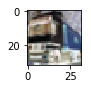

In [59]:
plt.figure(figsize=(1,1))
plt.imshow(X_train[1]) # 디폴트 (float32로 추정)

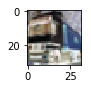

In [60]:
plt.figure(figsize=(1,1))
plt.imshow(X_train[1].astype('float32')) # 위와 동일

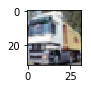

In [61]:
plt.figure(figsize=(1,1))
plt.imshow(X_train[1].astype('uint8')) # 0~255로 보기 # 반전????

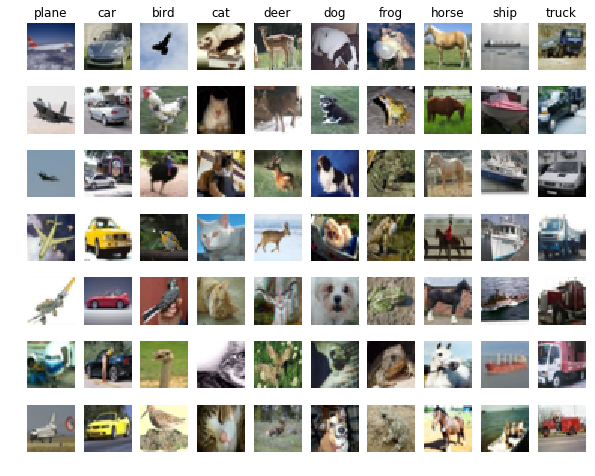

In [87]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes) # 10
samples_per_class = 7

# 첫번째 for loop에서는 각 column당 7개의 랜덤한 이미지를 뽑아주고, 
# 두번째 loop에서 이를 뿌려주고
# 다시 첫번째 loop은 이를 10번 반복한다
for y, cls in enumerate(classes): # 10회 반복. 0 plane -> 1 car -> ... -> 9 truck
    idxs = np.flatnonzero(y_train == y) # broadcast 통해서 순식간에 50,000번 연산해서 5,000개 뽑아내게 됨
    # print (len(idxs)) # 5000
    # print (idxs.shape) # (5000,)
    
    # flatnonzero()는 0이 아닌 원소들의 인덱스를 반환
    # x = np.arange(0,3)
    # x1 = np.flatnonzero(x)
    # print (x1) --> [1 2]

    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    # 중복 없이 5000개 중 7개를 랜덤하게 뽑는다
    # print (len(idxs)) # 7
    
    # 두번째 for loop에서는 첫번째 loop에서 추출한 column당 7개의 이미지를 뿌려준다
    for i, idx in enumerate(idxs): # i는 0~6, idx는 인덱스 (ex: 29468 32058 44618 26137 40125 12409  8199)
        plt_idx = i * num_classes + y + 1
        # subplot()에서 위치 지정해 주기 위해 plt_idx 계산 (1,11,...,61 -> 2,12,...,62 -> ... 10,20,...,70)
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # subplot(7,10,1), subplot(7,10,11),...,subplot(7,10,61)
        # subplot(7,10,2), subplot(7,10,12),...,subplot(7,10,62)
        # ...
        # subplot(7,10,10), subplot(7,10,20),...,subplot(7,10,70)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off') # off해 주지 않으면 각각의 subplot마다 X축/Y축 좌표가 지저분하게 보이게 된다
        if i == 0:
            plt.title(cls) # 첫줄의 경우에만 해당 클래스의 이름을 적어준다
plt.show() # 사실 안 적어줘도 된다!

# 테스트의 편의를 위해 데이터의 크기를 축소해 주자

* 학습용 데이터 : 50000 --> 5000
* 테스트용 데이터 : 10000 --> 500

In [88]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training)) # list로 형변환을 해 줌. 참고로 작년에는 그냥 range(num_training)이었고, 그렇게 해도 동일한 결과 나옴.
# print (type(mask)) # <class 'list'>

X_train = X_train[mask] # (5000, 32, 32, 3)
y_train = y_train[mask] # (5000,)

print (X_train.shape, y_train.shape)

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask] # (500, 32, 32, 3)
y_test = y_test[mask] # (500,)

print (X_test.shape, y_test.shape)

(5000, 32, 32, 3) (5000,)
(500, 32, 32, 3) (500,)


# 데이터 전처리 - 차원 조절

Vectorized 연산을 하기 위해 현재 rank4인 X_train과 X_test를 rank2로 만들어 준다
* X_train : (5000, (32x32x3) == (5000, 3072)
* X_test  : (500, 32x32x3) == (500, 3072)

In [89]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # -1은 나머지 모두 곱셈 # (5000,3072)
X_test = np.reshape(X_test, (X_test.shape[0], -1)) # (500, 3072)
# print(X_train.shape, X_test.shape)

# reshape() 예제
# Y1 = np.ones((3,4,5,6))
# Y2 = np.reshape(Y1, (Y1.shape[0], -1))
# print (Y2.shape) # (3,120)

# 가공 완료된 데이터를 이용해서 우리 모델을 학습시켜주자

학습은 그저 변수에 할당함으로써 메모리에 올리는 것으로 간단히 끝난다 
* self.X_train = X
* self.y_train = y

In [90]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor() 
classifier.train(X_train, y_train) # 학습 끝!
# KNearestNeighbor()의 함수 train의 내용은 단 2줄 : 
    # self.X_train = X
    # self.y_train = y

# 이제 테스트를 진행하자

1. 각각의 테스트 데이터를 모든 학습 데이터에 대해 비교하면서 distance를 구해 준다
2. distance가 작은 순으로 k개를 추린 다음에 이들이 다수결로 최종 레이블을 결정하게 한다. 

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the **distances** between all test examples and all train examples. 
2. Given these distances, for each test example we **find the k nearest examples and have them vote for the label**

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

# <테스트 1> Two loops (naive implementation)

소요시간 : 약 52초

In [91]:
# 숙제 #1
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test) # 테스트 총 500개
print(dists.shape) # 각각의 테스트 1개는 5,000개의 트레이닝과의 distance를 계산하게 된다

(500, 5000)


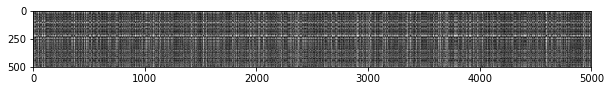

In [92]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show() # 생략해도 무방
# 흰줄이 나오는 라인은 특정 트레이닝 이미지 (240번 정도?) 가 outlier라 그런것 같은데,
# 어떤 이미지인지 찾아서 보는 것이 의미가 있을 것 같다. 

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



# 정확도를 확인해 보자 : 1) Nearest Neighbor인 경우 (k==1)

In [93]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1) # print (y_test_pred.shape) # (500,)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

# 연습

In [155]:
print(dists.shape)
dists[0][:10]

(500, 5000)


array([ 3803.92350081,  4210.59603857,  5504.0544147 ,  3473.88960677,
        4371.58632535,  4447.85127899,  3886.35060179,  4058.59187404,
        5175.54760388,  4678.74855063])

In [159]:
dists[0][:10].argsort() # argsort()는 작은수 -> 큰수로 정렬하고 해당 인덱스 반환

array([3, 0, 6, 7, 1, 4, 5, 9, 8, 2])

In [158]:
k=5
dists[0][:10].argsort()[:k]

array([3, 0, 6, 7, 1])

In [160]:
dists[1][:10]

array([ 6336.83367306,  5270.28006846,  4040.63608854,  6430.498892  ,
        5350.64407338,  6094.37987001,  5271.94688896,  6546.65173963,
        5710.24097565,  6404.07628   ])

In [161]:
dists[1][:10].argsort()[:k]

array([2, 1, 6, 4, 8])

In [163]:
# nearest_ys는 가장 distance가 작은 클래스
nearest_ys = y_train[dists[1][:10].argsort()[:5]]
nearest_ys

array([9, 9, 2, 1, 8])

In [165]:
np.bincount(nearest_ys) # one-hot 식으로 0~9로 표현. 9는 2개, 2와 1과 8은 1개, 나머지는 0개)
# bin (깡통) count

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 2])

In [167]:
np.argmax(np.bincount(nearest_ys)) # np.argmax()로 다수결에서 이기는 놈을 뽑아 줌

9

# 정확도를 확인해 보자 : 2) K-Nearest Neighbor인 경우 (k==5)

In [94]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

# <테스트 2> One loop (Partial Vectorization with one loop)

* One loop으로 dists_one을 구한다
* One loop으로 구한 dists_one과 앞에서 Two loops로 구한 dists가 같은지 확인해 준다.

소요 시간 : 약 56초

In [95]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro') # Frobenius norm을 이용해 차이를 계산한다
# Gram matrix는 행렬 vs. 행렬의 차이를 행렬로 나타내 준다 
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


# <테스트 3> No loop (Full vectorization)

* No loop으로 dists_two를 구한다
* No loop으로 구한 dists_two와 앞에서 Two loops로 구한 dists가 같은지 확인해 준다.

소요 시간 : 약 0.6초

In [96]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


# distance를 구한 세가지 방법의 소요시간을 비교해 보자

In [97]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 51.836027 seconds
One loop version took 57.982789 seconds
No loop version took 0.552646 seconds


소요시간 
* Two loop : 52초
* One loop : 56초
* No loop : 0.6초

# CV (Cross Validation) 를 통해 hyperparameter인 최적의 k를 구해 보자

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [98]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
# k_choices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

# np.array_split(리스트, 갯수) : 리스트를 갯수만큼으로 분산해 준다
# np.array_split()의 예제
# x = np.arange(8) # [0 1 2 3 4 5 6 7]
# x = np.array_split(x,3) # [array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]

X_train_folds = np.array_split(X_train, num_folds) # (5, 1000, 3072)
y_train_folds = np.array_split(y_train, num_folds) # (5, 1000)

# print (X_train.shape, np.array(X_train_folds).shape) # (5000, 3072) (5, 1000, 3072)
# print (y_train.shape, np.array(y_train_folds).shape) # (5000,) (5, 1000)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for k in k_choices:
    k_to_accuracies[k] = []

for k in k_choices: # 10번 반복
    print ('evaluating k=%d' % k)
    for j in range(num_folds): # 5번 반복
        X_train_cv = np.vstack(X_train_folds[0:j]+X_train_folds[j+1:]) # 첫번째 loop의 X의 training은 1,2,3,4에서 한다
        # j == 0 이면 N/A     + 1,2,3,4  = 1,2,3,4
        # j == 1 이면 0       + 2,3,4    = 2,3,4,0
        # j == 2 이면 0,1     + 3,4      = 3,4,0,1
        # j == 3 이면 0,1,2   + 4        = 4,0,1,2
        # j == 4 이면 0,1,2,3 + N/A      = 0,1,2,3
        # print (X_train_cv.shape)    # (4000,3072) # (1000,3072) 4개를 수직으로 쌓았으니까 (4000, 3072)가 된다.
        
        X_test_cv = X_train_folds[j] # 첫번째 loop의 X의 test는 0에서 한다
        # print (X_test_cv.shape)   # (1000,3072)
        
        # print (len(y_train_folds), y_train_folds[0].shape)
        # 5 (1000,)
        
        y_train_cv = np.hstack(y_train_folds[0:j]+y_train_folds[j+1:]) # 첫번째 loop의 y의 training은 1,2,3,4에서 한다
        # print (y_train_cv.shape)
        # (4000,) # (1000,)을 4개를 수평으로 쌓았으니까 (4000)이 된다
        
        y_test_cv = y_train_folds[j] # 첫번째 loop의 y의 테스트는 0에서 한다 
        #print (y_test_cv.shape)
        # (1000,)
        
#         print ('Training data shape: ', X_train_cv.shape) # (4000,3072)
#         print ('Training labels shape: ', y_train_cv.shape) # (4000,)
#         print ('Test data shape: ', X_test_cv.shape) # (1000,3072)
#         print ('Test labels shape: ', y_test_cv.shape) # (1000,)
        
        classifier.train(X_train_cv, y_train_cv)
        dists_cv = classifier.compute_distances_no_loops(X_test_cv) 
        # print (dists_cv.shape)   # (1000, 4000)
        print ('predicting now')
        y_test_pred = classifier.predict_labels(dists_cv, k)
        num_correct = np.sum(y_test_pred == y_test_cv)
        accuracy = float(num_correct) / num_test
        
        k_to_accuracies[k].append(accuracy)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

evaluating k=1
predicting now
predicting now
predicting now
predicting now
predicting now
evaluating k=3
predicting now
predicting now
predicting now
predicting now
predicting now
evaluating k=5
predicting now
predicting now
predicting now
predicting now
predicting now
evaluating k=8
predicting now
predicting now
predicting now
predicting now
predicting now
evaluating k=10
predicting now
predicting now
predicting now
predicting now
predicting now
evaluating k=12
predicting now
predicting now
predicting now
predicting now
predicting now
evaluating k=15
predicting now
predicting now
predicting now
predicting now
predicting now
evaluating k=20
predicting now
predicting now
predicting now
predicting now
predicting now
evaluating k=50
predicting now
predicting now
predicting now
predicting now
predicting now
evaluating k=100
predicting now
predicting now
predicting now
predicting now
predicting now
k = 1, accuracy = 0.526000
k = 1, accuracy = 0.514000
k = 1, accuracy = 0.528000
k = 1, accur

# 각 k일때의 정확도를 도식화해보자

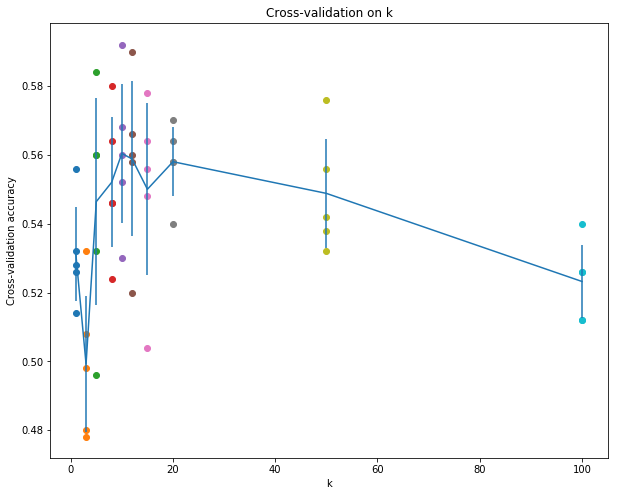

In [186]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    # print (len(accuracies)) # 5
    # print ([k]) # [1] [3] [5] [8] [10] [12] [15] [20] [50] [100]
    # print (k_to_accuracies)
    # {1: [0.204, 0.2, 0.194, 0.194, 0.218], 50: [0.204, 0.2, 0.194, 0.194, 0.218], 3: [0.204, 0.2, 0.194, 0.194, 0.218], 20: [0.204, 0.2, 0.194, 0.194, 0.218], 5: [0.204, 0.2, 0.194, 0.194, 0.218], 8: [0.204, 0.2, 0.194, 0.194, 0.218], 100: [0.204, 0.2, 0.194, 0.194, 0.218], 10: [0.204, 0.2, 0.194, 0.194, 0.218], 12: [0.204, 0.2, 0.194, 0.194, 0.218], 15: [0.204, 0.2, 0.194, 0.194, 0.218]}
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())]) # k=key, v=value임. 여기에서는 v만 활용
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())]) # 여기에서는 v만 활용

plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
# plt.show() # 안 써도 됨

In [191]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.

# best_k = 1
# best_k = 10

best_k = sorted(k_to_accuracies.keys())[np.argmax(accuracies_mean)] # 10
print ("The best k : ", best_k)

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

The best k :  10
Got 141 / 500 correct => accuracy: 0.282000
